In [1]:
import pandas as pd
from joblib import load
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import confusion_matrix, roc_auc_score

In [2]:
grid_results = pd.read_hdf('../models/logreg_gridsearch_results_v2.h5')
grid_model = load("../models/logreg_gridsearch_model_v2.joblib")

In [3]:
grid_results.sort_values('rank_test_F1-score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__max_iter,param_clf__penalty,param_clf__solver,param_qt__n_quantiles,param_qt__output_distribution,...,split3_test_Recall,split4_test_Recall,split5_test_Recall,split6_test_Recall,split7_test_Recall,split8_test_Recall,split9_test_Recall,mean_test_Recall,std_test_Recall,rank_test_Recall
11,12.411482,1.237269,5.282862,0.027463,0.0127427,1000,l2,saga,10,normal,...,0.958333,0.944444,0.916667,0.944444,0.986111,0.972222,0.930556,0.958333,0.024056,1
20,96.918124,26.014302,5.960327,1.579004,1.62378,1000,l1,saga,10,normal,...,0.944444,0.944444,0.888889,0.958333,0.986111,0.958333,0.916667,0.956944,0.033707,2
13,20.022752,1.821672,5.292354,0.049813,0.0335982,1000,l2,saga,10,normal,...,0.944444,0.944444,0.916667,0.944444,0.986111,0.972222,0.930556,0.956944,0.024414,2
25,65.256802,20.946709,6.294181,2.170124,11.2884,1000,l2,saga,10,normal,...,0.944444,0.930556,0.916667,0.930556,0.986111,0.972222,0.916667,0.956944,0.030713,2
21,53.245893,6.844768,4.957725,0.822788,1.62378,1000,l2,saga,10,normal,...,0.944444,0.930556,0.916667,0.930556,0.986111,0.972222,0.916667,0.955556,0.029659,5


In [6]:
model = grid_results.sort_values('rank_test_AUC').iloc[0,:]
model['params']

{'clf__C': 4.281332398719396,
 'clf__max_iter': 1000,
 'clf__penalty': 'l1',
 'clf__solver': 'saga',
 'qt__n_quantiles': 10,
 'qt__output_distribution': 'normal'}

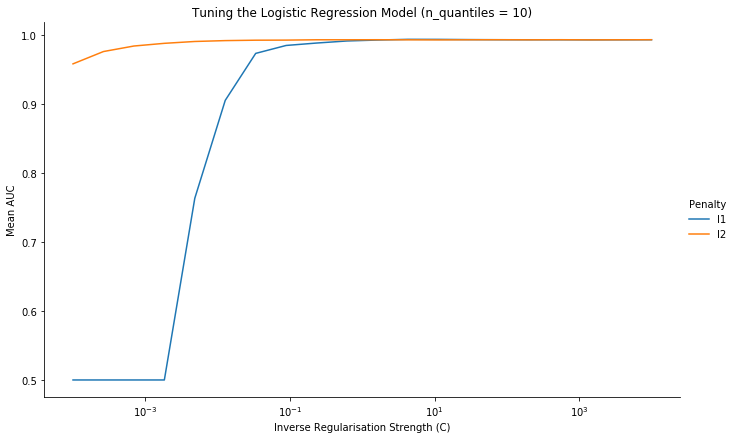

In [9]:
qt_10 = grid_results[grid_results['param_qt__n_quantiles'] == 10]
fg = sns.FacetGrid(data = grid_results, hue='param_clf__penalty', aspect=1.61, height=6)
fg.map(plt.semilogx, 'param_clf__C', 'mean_test_AUC').add_legend(title='Penalty')
fg.set(xlabel='Inverse Regularisation Strength (C)', ylabel='Mean AUC', title='Tuning the Logistic Regression Model (n_quantiles = 10)')
# plt.semilogx(grid_results['param_clf__C'], grid_results['mean_test_score'])
# fg.savefig('reports/figures/logreg_grid_penalty_qt_10_AUC')

In [14]:
# refit the model using best params
# do one for l2 and one for l1
X = pd.read_hdf('../data/features/filtered/filtered_0.05_.h5')
y = pd.read_hdf('../data/ach_at_combined_y.h5', key='y')

s = 1
for i in range(1,6):
    X.loc[90*(i-1):90*i,'subject'] = s
    s += 1
for i in range(1,7):
    X.loc[450+(60*(i-1)):450+(60*i),'subject'] = s
    s+=1
assert not any(pd.isna(X['subject']))

train = X[X['subject'] != 4].index
test = X[X['subject'] == 4].index

X_train, X_test, y_train, y_test = X.iloc[train,:], X.iloc[test,:], y.iloc[train], y.iloc[test]
model['params']

{'clf__C': 4.281332398719396,
 'clf__max_iter': 1000,
 'clf__penalty': 'l1',
 'clf__solver': 'saga',
 'qt__n_quantiles': 10,
 'qt__output_distribution': 'normal'}

In [12]:
best_l1 = Pipeline(steps=[('qt',
                 QuantileTransformer(copy=True, ignore_implicit_zeros=False,
                                     n_quantiles=10,
                                     output_distribution='normal',
                                     random_state=None, subsample=100000)),
                ('clf',
                 LogisticRegression(C=4.281332398719396, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=1000, multi_class='auto',
                                    n_jobs=None, penalty='l1',
                                    random_state=None, solver='saga',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)
best_l1.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('qt',
                 QuantileTransformer(copy=True, ignore_implicit_zeros=False,
                                     n_quantiles=10,
                                     output_distribution='normal',
                                     random_state=None, subsample=100000)),
                ('clf',
                 LogisticRegression(C=4.281332398719396, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=1000, multi_class='auto',
                                    n_jobs=None, penalty='l1',
                                    random_state=None, solver='saga',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)

In [13]:
y_pred_l1 = best_l1.predict(X_test)
print(confusion_matrix(y_test, y_pred_l1))



[[ 0 29  0]
 [ 0 30  0]
 [ 0 28  3]]


In [16]:
sub = X_train['subject']